In [1]:
!pip install wandb

ref: https://github.com/chaoshangcs/GTS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
!ls

/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS
'1. gts-graphbatt-train.ipynb'
'2. gts-graphbatt-benchmarking.ipynb'
'4. monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
'5. customWindow-monteCarlo-gts-gaets-graphbatt-train-evaluate.ipynb'
 data
 gts-debug.ipynb
 lib
 LICENSE
 model
 models
 pytorch-geometric-temporal.ipynb
 README.md
 requirements.txt
 runs
 scripts
 train.py
 wandb


In [4]:
import argparse
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

## monte carlo sweep

In [5]:
import os
import re

import torch

from tqdm.notebook import tqdm
import networkx as nx

class DummyTrainArgs():
  def __init__(self, config_filename, use_cpu_only, temperature):
    self.config_filename = config_filename
    self.use_cpu_only = use_cpu_only
    self.temperature = temperature

import argparse
import yaml
from importlib import reload
import model
reload(model)
from model.pytorch.supervisor import GTSSupervisor, GAETSSupervisor
from lib.utils import load_graph_data
import torch

import scripts.eval_baseline_methods

import argparse
import numpy as np
import pandas as pd

from statsmodels.tsa.vector_ar.var_model import VAR

# from lib import utils
from lib.metrics import masked_rmse_np, masked_mape_np, masked_mae_np
from lib.utils import StandardScaler

from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
""" Create Train Dataset """
train_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_81_1")
train_df = train_df.iloc[:2257]
train_df.set_index("Date_Time", inplace=True)
train_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5", key="df")

!python -m scripts.generate_training_data --output_dir=data/graphbatt/train --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_81_1.h5


Generating training data
x shape:  (1858, 80, 6, 1) , y shape:  (1858, 320, 6, 1)
train x:  (1301, 80, 6, 1) y: (1301, 320, 6, 1)
val x:  (185, 80, 6, 1) y: (185, 320, 6, 1)
test x:  (372, 80, 6, 1) y: (372, 320, 6, 1)


In [7]:
""" Create Test Dataset """
test_df = pd.read_excel("data/graphbatt/DOE-001-050-10DU_05.xlsx", sheet_name="Channel_82_1")
test_df = test_df.iloc[:2257]
test_df.set_index("Date_Time", inplace=True)
test_df[["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]].to_hdf("data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5", key="df")

# create larger portion of test data
!python -m scripts.generate_testing_data --output_dir=data/graphbatt/test --traffic_df_filename=data/graphbatt/DOE-001-050-10DU_05_Channel_82_1.h5

Generating testing data
x shape:  (1858, 80, 6, 1) , y shape:  (1858, 320, 6, 1)
train x:  (372, 80, 6, 1) y: (372, 320, 6, 1)
val x:  (185, 80, 6, 1) y: (185, 320, 6, 1)
test x:  (1301, 80, 6, 1) y: (1301, 320, 6, 1)


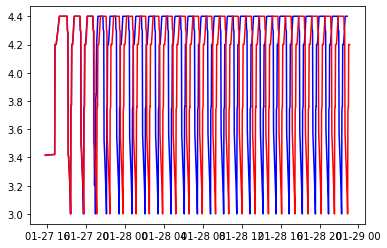

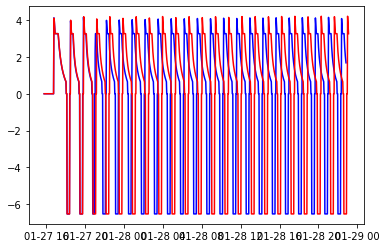

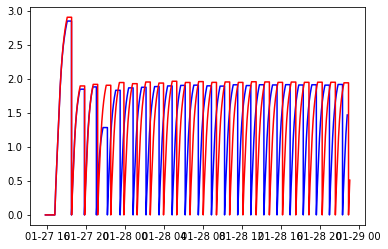

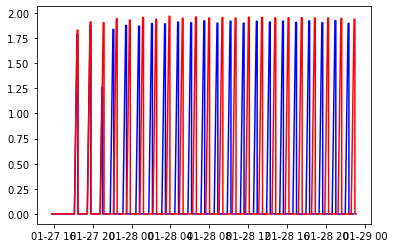

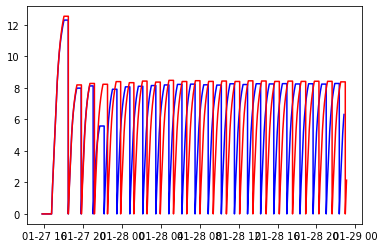

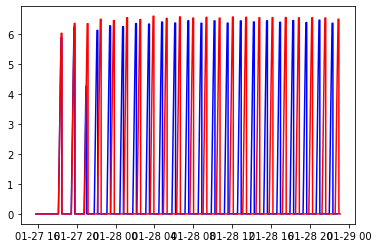

In [8]:
for col in ["Voltage(V)", "Current(A)", "Charge_Capacity(Ah)", "Discharge_Capacity(Ah)", "Charge_Energy(Wh)", "Discharge_Energy(Wh)"]:
  plt.plot(train_df[col].iloc[:1000], c="b")
  plt.plot(test_df[col].iloc[:1000], c="r")
  plt.show()

## train model

In [6]:
""" LOAD FROM DIFFERENT FILES """
import numpy as np
from lib.utils import DataLoader

# load test dataset
def create_test_iterator(supervisor, supervisor_config, test_dataset_dir = "data/graphbatt/test"):
  data = {}
  category = 'test'
  cat_data = np.load(os.path.join(test_dataset_dir, category + '.npz'))
  _x = cat_data['x']
  _y = cat_data['y']
  # use scaler from supervisor trained's scaler
  scaler = supervisor.train_scaler
  _x[..., 0] = scaler.transform(_x[..., 0])
  _y[..., 0] = scaler.transform(_y[..., 0])
  test_loader = DataLoader(_x, _y, supervisor_config["data"]["test_batch_size"], shuffle=False)

  return test_loader.get_iterator()

2021-09-27 15:05:31,823 - INFO - Log directory: data/model/GTS_DR_2_h_40_64_lr_0.005_bs_64_0927150528/
2021-09-27 15:05:41,292 - INFO - Model created


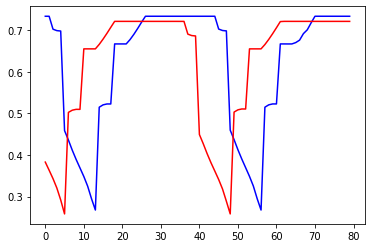

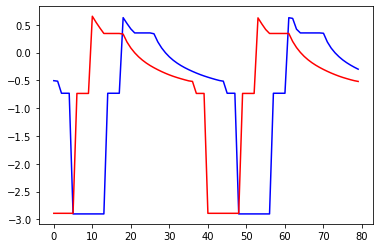

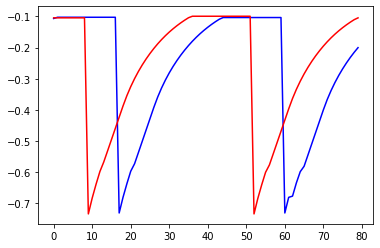

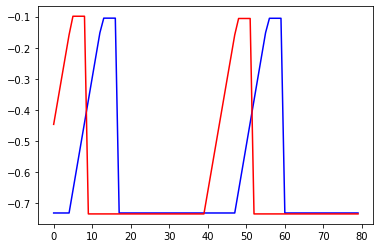

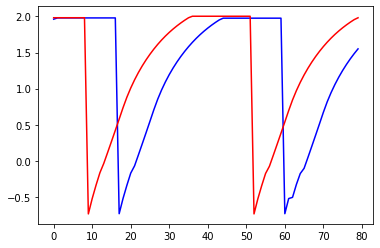

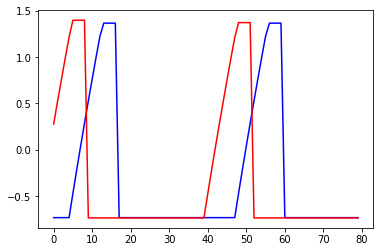

In [10]:
# inspect data
# load model and test dataset
args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
# test_args = DummyTrainArgs(config_filename="data/model/para_graphbatt_test.yaml", use_cpu_only=False, temperature=0.5)
with open(args.config_filename) as f:
    supervisor_config = yaml.load(f)
    save_adj_name = args.config_filename[11:-5]
    supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)

# manual iterator
gts_train_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/train")
_x, _y = list(gts_train_iterator)[0]

# train iterator
_x_train, _y_train = list(supervisor_gts._data["train_loader"].get_iterator())[0]

for i in range(6):
  plt.plot(_x[0, :, i, 0], c="b")
  plt.plot(_x_train[0, :, i, 0], c="r")
  plt.show()

In [7]:
# number of monte carlo iteration
num_mc = 1 #5

In [8]:
"""
TRAIN AND TEST ON THE SAME FILE
hypothesis: need early stopping i.e. by epoch 13, otherwise model overfits and stops performing well even in test files
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mc_scores = []
for mc_round in tqdm(range(num_mc)):

  # load model and test dataset
  args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
  with open(args.config_filename) as f:
      supervisor_config = yaml.load(f)
      save_adj_name = args.config_filename[11:-5]
      supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gts.GTS_model.use_curriculum_learning = False
      supervisor_gts.train()
      supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gaets.GTS_model.use_curriculum_learning = False
      supervisor_gaets.train()


  # get largest epoch
  files = os.listdir("models/GTS")
  largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  files = os.listdir("models/GAETS")
  largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

  # Load Model
  supervisor_gts._epoch_num = largestGTSEpoch
  supervisor_gts.load_model()
  supervisor_gaets._epoch_num = largestGAETSEpoch
  supervisor_gaets.load_model()
  label = "with_regularization"
  temp_gts = supervisor_gts.temperature
  temp_gaets = supervisor_gaets.temperature
  gumbel_soft = True
  batches_seen = 1

  # get test data from unseen dataset
  gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
  gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")
  
  """
  COMPARE PERFORMANCE
  """
  # for each batch
  var_rmses = []
  var_mapes = []
  var_maes = []
  gts_rmses = []
  gts_mapes = []
  gts_maes = []
  gaets_rmses = []
  gaets_mapes = []
  gaets_maes = []

  # for each batch
  for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
    """ GAETS """
    x, y = supervisor_gaets._prepare_data(_x, _y)
    # supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
    supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.eval()
    output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      gaets_prediction = output[:, i, :].cpu().numpy()
      gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gaets_rmse) < np.float("inf"):
        gaets_rmses.append(gaets_rmse)
      if abs(gaets_mape) < np.float("inf"):
        gaets_mapes.append(gaets_mape)
      if abs(gaets_mae) < np.float("inf"):
        gaets_maes.append(gaets_mae)

    """ VAR """
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      input = x[:, i, :].cpu().numpy()

      # fit VAR model on input
      var_model = VAR(input)
      # TODO: choose best lag
      var_result = var_model.fit(31)
      var_prediction = var_result.forecast(input, 320)

      var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
      var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
      var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

      # keep track
      if abs(var_rmse) < np.float("inf"):
        var_rmses.append(var_rmse)
      if abs(var_mape) < np.float("inf"):
        var_mapes.append(var_mape)
      if abs(var_mae) < np.float("inf"):
        var_maes.append(var_mae)

  """ GTS """
  for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
    x, y = supervisor_gts._prepare_data(_x, _y)
    # supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
    supervisor_gts.GTS_model = supervisor_gts.GTS_model.eval()
    output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].cpu().numpy()
      gts_prediction = output[:, i, :].cpu().numpy()
      gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gts_rmse) < np.float("inf"):
        gts_rmses.append(gts_rmse)
      if abs(gts_mape) < np.float("inf"):
        gts_mapes.append(gts_mape)
      if abs(gts_mae) < np.float("inf"):
        gts_maes.append(gts_mae)

  """
  get score
  """
  scoreMedianDict = {
    "GAETS": {
        "RMSE": np.median(gaets_rmses), 
        "MAPE": np.median(gaets_mapes), 
        "MAE": np.median(gaets_maes), 
        "RMS data points": len(gaets_rmses), 
        "MAPE data points": len(gaets_mapes), 
        "MAE data points": len(gaets_maes),
        "Best Epoch": largestGAETSEpoch
    },
    "GTS": {
        "RMSE": np.median(gts_rmses), 
        "MAPE": np.median(gts_mapes), 
        "MAE": np.median(gts_maes), 
        "RMS data points": len(gts_rmses), 
        "MAPE data points": len(gts_mapes), 
        "MAE data points": len(gts_maes),
        "Best Epoch": largestGTSEpoch
    },
    "VAR": {
        "RMSE": np.median(var_rmses), 
        "MAPE": np.median(var_mapes), 
        "MAE": np.median(var_maes), 
        "RMS data points": len(var_rmses), 
        "MAPE data points": len(var_mapes), 
        "MAE data points": len(var_maes),
        "Best Epoch": -1
    },
  }
  print(mc_round, scoreMedianDict)
  mc_scores.append(scoreMedianDict)

  # remove model
  !rm models/GTS/*
  !rm models/GAETS/*

  0%|          | 0/1 [00:00<?, ?it/s]

2021-09-27 15:13:47,228 - INFO - Log directory: data/model/GTS_DR_2_h_320_64_lr_0.005_bs_64_0927151347/
2021-09-27 15:13:49,648 - INFO - Model created


wandb: Currently logged in as: eekosasih (use `wandb login --relogin` to force relogin)


2021-09-27 15:14:02,641 - INFO - Start training ...
2021-09-27 15:14:02,647 - INFO - num_batches:21
Num of epoch: 0
2021-09-27 15:14:03,417 - INFO - Total trainable parameters 2596563
2021-09-27 15:14:28,741 - INFO - epoch complete
2021-09-27 15:14:28,743 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 15:14:30,299 - INFO - Epoch [0/50] (21) train_mae: 2.5456, val_mae: 2.6322
2021-09-27 15:14:30,358 - INFO - Saved model at 0
2021-09-27 15:14:30,361 - INFO - Val loss decrease from inf to 2.6322, saving to models/GTS/epo0.tar
Num of epoch: 1
2021-09-27 15:14:56,310 - INFO - epoch complete
2021-09-27 15:14:56,314 - INFO - evaluating now!
2021-09-27 15:14:57,891 - INFO - Epoch [1/50] (42) train_mae: 2.0497, val_mae: 2.2927
2021-09-27 15:14:57,948 - INFO - Saved model at 1
2021-09-27 15:14:57,950 - INFO - Val loss decrease from 2.6322 to 2.2927, saving to models/GTS/epo1.tar
Num of epoch: 2
2021-09-27 15:15:23,651 - INFO - epoch complete
2021-09-27 15:15:23,652 - INFO - evaluating now!
2021-09-27 15:15:25,199 - INFO - Epoch [2/50] (63) train_mae: 1.8855, val_mae: 2.3391
Num of epoch: 3
2021-09-27 15:15:50,676 - INFO - epoch complete
2021-09-27 15:15:50,679 - INFO - evaluating now!
2021-09-27 15:15:52,157 - INFO - Epoch [3/50] (84) train_mae: 1.7816, val_mae: 2.2359
2021-09-27 1

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 15:16:48,339 - INFO - epoch complete
2021-09-27 15:16:48,344 - INFO - evaluating now!
2021-09-27 15:16:49,834 - INFO - Epoch [5/50] (126) train_mae: 1.6204, val_mae: 2.0885
2021-09-27 15:16:49,893 - INFO - Saved model at 5
2021-09-27 15:16:49,896 - INFO - Val loss decrease from 2.2153 to 2.0885, saving to models/GTS/epo5.tar
Num of epoch: 6
2021-09-27 15:17:15,579 - INFO - epoch complete
2021-09-27 15:17:15,581 - INFO - evaluating now!
2021-09-27 15:17:17,093 - INFO - Epoch [6/50] (147) train_mae: 1.5100, val_mae: 1.9906
2021-09-27 15:17:17,148 - INFO - Saved model at 6
2021-09-27 15:17:17,151 - INFO - Val loss decrease from 2.0885 to 1.9906, saving to models/GTS/epo6.tar
Num of epoch: 7
2021-09-27 15:17:43,075 - INFO - epoch complete
2021-09-27 15:17:43,079 - INFO - evaluating now!
2021-09-27 15:17:44,678 - INFO - Epoch [7/50] (168) train_mae: 1.4342, val_mae: 2.0428
Num of epoch: 8
2021-09-27 15:18:10,908 - INFO - epoch complete
2021-09-27 15:18:10,909 - INFO - evaluating 

testing loss,1.67318
training loss,1.10466
validation loss,1.68208


testing loss,█▃▁▁▂▁▄▁▁▁
training loss,█▆▅▄▄▃▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▆▅▄▄▄▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁


2021-09-27 15:37:42,563 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0927153742/
2021-09-27 15:37:42,563 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0927153742/
2021-09-27 15:37:42,771 - INFO - Model created
2021-09-27 15:37:42,771 - INFO - Model created


2021-09-27 15:37:50,313 - INFO - Start training ...
2021-09-27 15:37:50,313 - INFO - Start training ...
2021-09-27 15:37:50,331 - INFO - num_batches:21
2021-09-27 15:37:50,331 - INFO - num_batches:21
Num of epoch: 0
2021-09-27 15:37:50,975 - INFO - Total trainable parameters 3072347
2021-09-27 15:37:50,975 - INFO - Total trainable parameters 3072347
2021-09-27 15:38:16,429 - INFO - epoch complete
2021-09-27 15:38:16,429 - INFO - epoch complete
2021-09-27 15:38:16,440 - INFO - evaluating now!
2021-09-27 15:38:16,440 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-27 15:38:18,014 - INFO - Epoch [0/50] (21) train_mae: 3.8814, val_mae: 3.4443
2021-09-27 15:38:18,014 - INFO - Epoch [0/50] (21) train_mae: 3.8814, val_mae: 3.4443
2021-09-27 15:38:19,186 - INFO - Saved model at 0
2021-09-27 15:38:19,186 - INFO - Saved model at 0
2021-09-27 15:38:19,197 - INFO - Val loss decrease from inf to 3.4443, saving to models/GAETS/epo0.tar
2021-09-27 15:38:19,197 - INFO - Val loss decrease from inf to 3.4443, saving to models/GAETS/epo0.tar
Num of epoch: 1
2021-09-27 15:38:45,619 - INFO - epoch complete
2021-09-27 15:38:45,619 - INFO - epoch complete
2021-09-27 15:38:45,626 - INFO - evaluating now!
2021-09-27 15:38:45,626 - INFO - evaluating now!
2021-09-27 15:38:47,241 - INFO - Epoch [1/50] (42) train_mae: 3.2049, val_mae: 3.0697
2021-09-27 15:38:47,241 - INFO - Epoch [1/50] (42) train_mae: 3.2049, val_mae: 3.0697
2021-09-27 15:38:48,104 - INFO - Saved model at 1
2021-09-27 15:38:48,104 - INFO - Saved model at 1
2021-09-27 15:38:48,117 - INFO - Val los

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-27 15:40:41,695 - INFO - epoch complete
2021-09-27 15:40:41,695 - INFO - epoch complete
2021-09-27 15:40:41,702 - INFO - evaluating now!
2021-09-27 15:40:41,702 - INFO - evaluating now!
2021-09-27 15:40:43,310 - INFO - Epoch [5/50] (126) train_mae: 2.1696, val_mae: 2.2020
2021-09-27 15:40:43,310 - INFO - Epoch [5/50] (126) train_mae: 2.1696, val_mae: 2.2020
2021-09-27 15:40:43,379 - INFO - Saved model at 5
2021-09-27 15:40:43,379 - INFO - Saved model at 5
2021-09-27 15:40:43,387 - INFO - Val loss decrease from 2.3233 to 2.2020, saving to models/GAETS/epo5.tar
2021-09-27 15:40:43,387 - INFO - Val loss decrease from 2.3233 to 2.2020, saving to models/GAETS/epo5.tar
Num of epoch: 6
2021-09-27 15:41:09,597 - INFO - epoch complete
2021-09-27 15:41:09,597 - INFO - epoch complete
2021-09-27 15:41:09,605 - INFO - evaluating now!
2021-09-27 15:41:09,605 - INFO - evaluating now!
2021-09-27 15:41:11,140 - INFO - Epoch [6/50] (147) train_mae: 2.1676, val_mae: 2.1635
2021-09-27 15:41:11,140

testing loss,1.3094
training loss,1.14562
validation loss,1.31904


testing loss,▇█▂▁▁▂▁▁▁▁
training loss,█▆▅▄▄▄▄▄▃▂▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▄▄▄▄▃▅▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁


best GTS epoch: 48 and GAETS epoch: 47
2021-09-27 16:02:11,711 - INFO - Loaded model at 48
2021-09-27 16:02:11,711 - INFO - Loaded model at 48
2021-09-27 16:02:11,748 - INFO - Loaded model at 47
2021-09-27 16:02:11,748 - INFO - Loaded model at 47


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:96: RuntimeWarning: overflow encountered in true_divide
  mape = np.abs(np.divide(np.subtract(preds, labels).astype('float32'), labels))
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:70: RuntimeWarning: overflow encountered in square
  rmse = np.square(np.subtract(preds, labels)).astype('float32')


0it [00:00, ?it/s]

0 {'GAETS': {'RMSE': 0.6957028, 'MAPE': 1.241409, 'MAE': 0.3559116, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 47}, 'GTS': {'RMSE': 0.70290995, 'MAPE': 1.2161071, 'MAE': 0.35444766, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 48}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}


In [ ]:
# # past runs

# mc_scores = [
# {'GAETS': {'RMSE': 0.18212958, 'MAPE': 0.0570608, 'MAE': 0.03278192, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 39}, 'GTS': {'RMSE': 0.25220072, 'MAPE': 0.090299144, 'MAE': 0.047529332, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 20}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}},
# {'GAETS': {'RMSE': 0.18871263, 'MAPE': 0.06087143, 'MAE': 0.031443894, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 26}, 'GTS': {'RMSE': 0.30276787, 'MAPE': 0.3311696, 'MAE': 0.11805564, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 2}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}},
# {'GAETS': {'RMSE': 0.16878107, 'MAPE': 0.04395973, 'MAE': 0.027053323, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 45}, 'GTS': {'RMSE': 0.2773063, 'MAPE': 0.11752401, 'MAE': 0.06213769, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 8}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}},
# {'GAETS': {'RMSE': 0.1758976, 'MAPE': 0.04456696, 'MAE': 0.033198252, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 47}, 'GTS': {'RMSE': 0.2772724, 'MAPE': 0.11742808, 'MAE': 0.05730006, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 9}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}},
# {'GAETS': {'RMSE': 0.18239018, 'MAPE': 0.052665398, 'MAE': 0.033586875, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 38}, 'GTS': {'RMSE': 0.30349982, 'MAPE': 0.2920389, 'MAE': 0.103953004, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 2}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}
# ]

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
""" Score Dataframe """

# create dataframe
mc_scores_df = None
for i, scoreMedianDict in enumerate(mc_scores):
  temp = pd.DataFrame(scoreMedianDict).T
  temp["MC Count"] = i
  if mc_scores_df is None:
    mc_scores_df = temp
  else:
    mc_scores_df = pd.concat([mc_scores_df, temp])

mc_scores_df

,RMSE,MAPE,MAE,RMS data points,MAPE data points,MAE data points,Best Epoch,MC Count
GAETS,0.695703,1.241409,0.355912,1344.0,1344.0,1344.0,47.0,0
GTS,0.702910,1.216107,0.354448,1344.0,1344.0,1344.0,48.0,0
VAR,0.403253,0.525425,0.135626,1290.0,1316.0,1316.0,-1.0,0


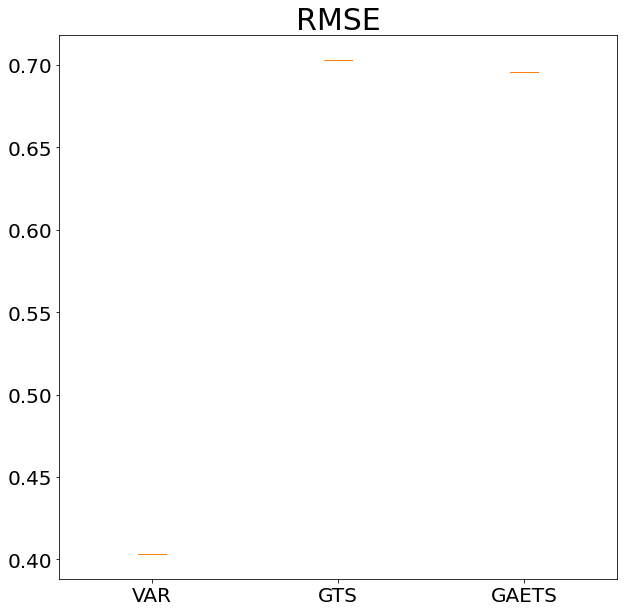

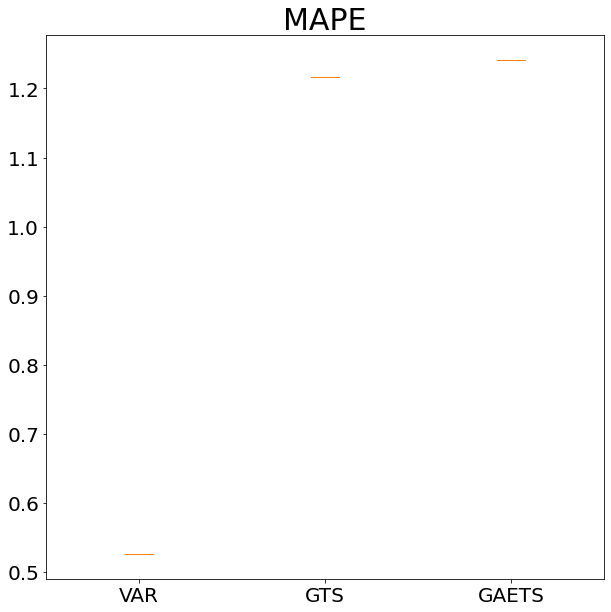

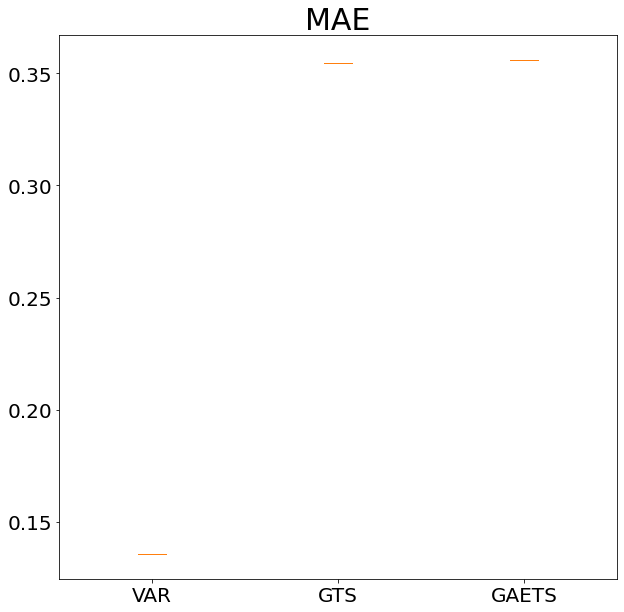

In [11]:
""" Score Visualisation """

score_ticks = ["RMSE", "MAPE", "MAE"]
list_models = ["VAR", "GTS", "GAETS"]

for score_name in score_ticks:

  plt.figure(figsize=(10, 10))
  plt.title(score_name, fontsize=30)
  scoreDF = mc_scores_df[[score_name]]
  for i, model_name in enumerate(list_models):
    score_value = scoreDF[scoreDF.index == model_name].values
    plt.boxplot(score_value, positions=[i], showfliers=False)
  plt.xticks(range(len(list_models)), list_models, fontsize=20)
  plt.yticks(fontsize=20)
  plt.plot()
  plt.show()

  print("")

In [ ]:
# visualise result
"""
VISUALISE
"""

# get largest epoch
files = os.listdir("models/GTS")
largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
files = os.listdir("models/GAETS")
largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# Load Model
supervisor_gts._epoch_num = largestGTSEpoch
supervisor_gts.load_model()
supervisor_gaets._epoch_num = largestGAETSEpoch
supervisor_gaets.load_model()
label = "with_regularization"
temp_gts = supervisor_gts.temperature
temp_gaets = supervisor_gaets.temperature
gumbel_soft = True
batches_seen = 1

# get test data from unseen dataset
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gaets_prediction = output[:, i, :].cpu().numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

    # break
  break



""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    gts_prediction = output[:, i, :].cpu().numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

    # break

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].cpu().numpy()
    input = x[:, i, :].cpu().numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 320)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)

    # break
  break

# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

In [14]:
{
  "GAETS": {
      "RMSE": np.median(gaets_rmses), 
      "MAPE": np.median(gaets_mapes), 
      "MAE": np.median(gaets_maes), 
      "RMS data points": len(gaets_rmses), 
      "MAPE data points": len(gaets_mapes), 
      "MAE data points": len(gaets_maes),
      "Best Epoch": largestGAETSEpoch
  },
  "GTS": {
      "RMSE": np.median(gts_rmses), 
      "MAPE": np.median(gts_mapes), 
      "MAE": np.median(gts_maes), 
      "RMS data points": len(gts_rmses), 
      "MAPE data points": len(gts_mapes), 
      "MAE data points": len(gts_maes),
      "Best Epoch": largestGTSEpoch
  },
  "VAR": {
      "RMSE": np.median(var_rmses), 
      "MAPE": np.median(var_mapes), 
      "MAE": np.median(var_maes), 
      "RMS data points": len(var_rmses), 
      "MAPE data points": len(var_mapes), 
      "MAE data points": len(var_maes),
      "Best Epoch": -1
  },
}

{'GAETS': {'Best Epoch': 47,
  'MAE': 0.36536154,
  'MAE data points': 64,
  'MAPE': 1.2298548,
  'MAPE data points': 64,
  'RMS data points': 64,
  'RMSE': 0.70649815},
 'GTS': {'Best Epoch': 48,
  'MAE': 0.36298275,
  'MAE data points': 64,
  'MAPE': 1.2405531,
  'MAPE data points': 64,
  'RMS data points': 64,
  'RMSE': 0.7094675},
 'VAR': {'Best Epoch': -1,
  'MAE': 696.8288,
  'MAE data points': 52,
  'MAPE': 2011.4417,
  'MAPE data points': 52,
  'RMS data points': 47,
  'RMSE': 5.27229}}

## debug larger data

In [ ]:
"""
TRAIN AND TEST ON LONGER ITERATION i.e. 100 instead of 20
"""
num_mc = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mc_scores = []
for mc_round in tqdm(range(num_mc)):

  # load model and test dataset
  args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
  with open(args.config_filename) as f:
      supervisor_config = yaml.load(f)
      supervisor_config["train"]["epochs"] = 100
      save_adj_name = args.config_filename[11:-5]
      supervisor_gts = GTSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gts.train()
      supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
      supervisor_gaets.train()


  # get largest epoch
  files = os.listdir("models/GTS")
  largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  files = os.listdir("models/GAETS")
  largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
  print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

  # Load Model
  supervisor_gts._epoch_num = largestGTSEpoch
  supervisor_gts.load_model()
  supervisor_gaets._epoch_num = largestGAETSEpoch
  supervisor_gaets.load_model()
  label = "with_regularization"
  temp_gts = supervisor_gts.temperature
  temp_gaets = supervisor_gaets.temperature
  gumbel_soft = True
  batches_seen = 1

  # get test data from unseen dataset
  gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
  gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")
  
  """
  COMPARE PERFORMANCE
  """
  # for each batch
  var_rmses = []
  var_mapes = []
  var_maes = []
  gts_rmses = []
  gts_mapes = []
  gts_maes = []
  gaets_rmses = []
  gaets_mapes = []
  gaets_maes = []

  # for each batch
  for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
    """ GAETS """
    x, y = supervisor_gaets._prepare_data(_x, _y)
    supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
    output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].numpy()
      gaets_prediction = output[:, i, :].numpy()
      gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
      gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gaets_rmse) < np.float("inf"):
        gaets_rmses.append(gaets_rmse)
      if abs(gaets_mape) < np.float("inf"):
        gaets_mapes.append(gaets_mape)
      if abs(gaets_mae) < np.float("inf"):
        gaets_maes.append(gaets_mae)

    """ VAR """
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].numpy()
      input = x[:, i, :].numpy()

      # fit VAR model on input
      var_model = VAR(input)
      # TODO: choose best lag
      var_result = var_model.fit(31)
      var_prediction = var_result.forecast(input, 320)

      var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
      var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
      var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

      # keep track
      if abs(var_rmse) < np.float("inf"):
        var_rmses.append(var_rmse)
      if abs(var_mape) < np.float("inf"):
        var_mapes.append(var_mape)
      if abs(var_mae) < np.float("inf"):
        var_maes.append(var_mae)

  """ GTS """
  for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
    x, y = supervisor_gts._prepare_data(_x, _y)
    supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
    output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
    output = output.detach()
    # for each batch
    for i in range(x.shape[1]):
      labels = y[:, i, :].numpy()
      gts_prediction = output[:, i, :].numpy()
      gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
      gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

      # keep track
      if abs(gts_rmse) < np.float("inf"):
        gts_rmses.append(gts_rmse)
      if abs(gts_mape) < np.float("inf"):
        gts_mapes.append(gts_mape)
      if abs(gts_mae) < np.float("inf"):
        gts_maes.append(gts_mae)

  """
  get score
  """
  scoreMedianDict = {
    "GAETS": {
        "RMSE": np.median(gaets_rmses), 
        "MAPE": np.median(gaets_mapes), 
        "MAE": np.median(gaets_maes), 
        "RMS data points": len(gaets_rmses), 
        "MAPE data points": len(gaets_mapes), 
        "MAE data points": len(gaets_maes),
        "Best Epoch": largestGAETSEpoch
    },
    "GTS": {
        "RMSE": np.median(gts_rmses), 
        "MAPE": np.median(gts_mapes), 
        "MAE": np.median(gts_maes), 
        "RMS data points": len(gts_rmses), 
        "MAPE data points": len(gts_mapes), 
        "MAE data points": len(gts_maes),
        "Best Epoch": largestGTSEpoch
    },
    "VAR": {
        "RMSE": np.median(var_rmses), 
        "MAPE": np.median(var_mapes), 
        "MAE": np.median(var_maes), 
        "RMS data points": len(var_rmses), 
        "MAPE data points": len(var_mapes), 
        "MAE data points": len(var_maes),
        "Best Epoch": -1
    },
  }
  print(mc_round, scoreMedianDict)
  mc_scores.append(scoreMedianDict)

  # remove model
  !rm models/GTS/*
  !rm models/GAETS/*

  0%|          | 0/2 [00:00<?, ?it/s]

2021-09-23 07:50:56,344 - INFO - Log directory: data/model/GTS_DR_2_h_320_64_lr_0.005_bs_64_0923075054/
2021-09-23 07:50:59,327 - INFO - Model created


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


2021-09-23 07:51:18,419 - INFO - Start training ...
2021-09-23 07:51:18,422 - INFO - num_batches:21
Num of epoch: 0
2021-09-23 07:51:20,433 - INFO - Total trainable parameters 2596563
2021-09-23 07:52:07,495 - INFO - epoch complete
2021-09-23 07:52:07,501 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-23 07:52:09,907 - INFO - Epoch [0/100] (21) train_mae: 1.8479, val_mae: 4.1031
2021-09-23 07:52:10,871 - INFO - Saved model at 0
2021-09-23 07:52:10,873 - INFO - Val loss decrease from inf to 4.1031, saving to models/GTS/epo0.tar
Num of epoch: 1
2021-09-23 07:52:58,230 - INFO - epoch complete
2021-09-23 07:52:58,233 - INFO - evaluating now!
2021-09-23 07:53:00,540 - INFO - Epoch [1/100] (42) train_mae: 0.9212, val_mae: 5.1713
Num of epoch: 2
2021-09-23 07:53:47,695 - INFO - epoch complete
2021-09-23 07:53:47,698 - INFO - evaluating now!
2021-09-23 07:53:50,014 - INFO - Epoch [2/100] (63) train_mae: 0.5453, val_mae: 6.8762
Num of epoch: 3
2021-09-23 07:54:37,660 - INFO - epoch complete
2021-09-23 07:54:37,663 - INFO - evaluating now!
2021-09-23 07:54:39,976 - INFO - Epoch [3/100] (84) train_mae: 0.3479, val_mae: 7.7909
Num of epoch: 4
2021-09-23 07:55:27,596 - INFO - epoch complete
2021-09-23 07:55:27,598 - INFO - evaluating now!
2021-09-23 07:55:29,958 - INFO - Epoch [4/100] (1

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-23 07:56:22,498 - INFO - epoch complete
2021-09-23 07:56:22,503 - INFO - evaluating now!
2021-09-23 07:56:24,847 - INFO - Epoch [5/100] (126) train_mae: 0.2361, val_mae: 4.9647
Num of epoch: 6
2021-09-23 07:57:12,171 - INFO - epoch complete
2021-09-23 07:57:12,173 - INFO - evaluating now!
2021-09-23 07:57:14,518 - INFO - Epoch [6/100] (147) train_mae: 0.1983, val_mae: 4.7613
Num of epoch: 7
2021-09-23 07:58:02,076 - INFO - epoch complete
2021-09-23 07:58:02,078 - INFO - evaluating now!
2021-09-23 07:58:04,426 - INFO - Epoch [7/100] (168) train_mae: 0.1970, val_mae: 7.6368
Num of epoch: 8
2021-09-23 07:58:51,787 - INFO - epoch complete
2021-09-23 07:58:51,789 - INFO - evaluating now!
2021-09-23 07:58:54,103 - INFO - Epoch [8/100] (189) train_mae: 0.2036, val_mae: 3.8316
Num of epoch: 9
2021-09-23 07:59:41,479 - INFO - epoch complete
2021-09-23 07:59:41,481 - INFO - evaluating now!
2021-09-23 07:59:43,838 - INFO - Epoch [9/100] (210) train_mae: 0.1839, val_mae: 5.4187
2021-09-23 

testing loss,2.86371
training loss,0.07093
validation loss,2.84889


testing loss,▂▆▇█▆█▄▇▅▄▂▁▂▁▂▂▂▁▂▁
training loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,▃▇▄█▄▄▆▂▄▄▆▄▅▅▅▄▄▃▅▄▄▃▃▁▂▁▂▂▁▁▂▂▂▂▂▂▂▂▁▁


2021-09-23 09:17:19,931 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923091719/
2021-09-23 09:17:19,931 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923091719/
2021-09-23 09:17:20,160 - INFO - Model created
2021-09-23 09:17:20,160 - INFO - Model created


wandb: Currently logged in as: eekosasih (use `wandb login --relogin` to force relogin)


2021-09-23 09:17:27,913 - INFO - Start training ...
2021-09-23 09:17:27,913 - INFO - Start training ...
2021-09-23 09:17:27,923 - INFO - num_batches:21
2021-09-23 09:17:27,923 - INFO - num_batches:21
Num of epoch: 0
2021-09-23 09:17:29,136 - INFO - Total trainable parameters 3072347
2021-09-23 09:17:29,136 - INFO - Total trainable parameters 3072347
2021-09-23 09:18:15,616 - INFO - epoch complete
2021-09-23 09:18:15,616 - INFO - epoch complete
2021-09-23 09:18:15,626 - INFO - evaluating now!
2021-09-23 09:18:15,626 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-23 09:18:17,986 - INFO - Epoch [0/100] (21) train_mae: 3.1895, val_mae: 4.0314
2021-09-23 09:18:17,986 - INFO - Epoch [0/100] (21) train_mae: 3.1895, val_mae: 4.0314
2021-09-23 09:18:19,120 - INFO - Saved model at 0
2021-09-23 09:18:19,120 - INFO - Saved model at 0
2021-09-23 09:18:19,130 - INFO - Val loss decrease from inf to 4.0314, saving to models/GAETS/epo0.tar
2021-09-23 09:18:19,130 - INFO - Val loss decrease from inf to 4.0314, saving to models/GAETS/epo0.tar
Num of epoch: 1
2021-09-23 09:19:06,370 - INFO - epoch complete
2021-09-23 09:19:06,370 - INFO - epoch complete
2021-09-23 09:19:06,377 - INFO - evaluating now!
2021-09-23 09:19:06,377 - INFO - evaluating now!
2021-09-23 09:19:08,702 - INFO - Epoch [1/100] (42) train_mae: 1.8946, val_mae: 2.9735
2021-09-23 09:19:08,702 - INFO - Epoch [1/100] (42) train_mae: 1.8946, val_mae: 2.9735
2021-09-23 09:19:09,371 - INFO - Saved model at 1
2021-09-23 09:19:09,371 - INFO - Saved model at 1
2021-09-23 09:19:09,381 - INFO - Val

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-23 09:22:29,561 - INFO - epoch complete
2021-09-23 09:22:29,561 - INFO - epoch complete
2021-09-23 09:22:29,572 - INFO - evaluating now!
2021-09-23 09:22:29,572 - INFO - evaluating now!
2021-09-23 09:22:31,883 - INFO - Epoch [5/100] (126) train_mae: 0.3050, val_mae: 1.8855
2021-09-23 09:22:31,883 - INFO - Epoch [5/100] (126) train_mae: 0.3050, val_mae: 1.8855
2021-09-23 09:22:31,944 - INFO - Saved model at 5
2021-09-23 09:22:31,944 - INFO - Saved model at 5
2021-09-23 09:22:31,953 - INFO - Val loss decrease from 2.4944 to 1.8855, saving to models/GAETS/epo5.tar
2021-09-23 09:22:31,953 - INFO - Val loss decrease from 2.4944 to 1.8855, saving to models/GAETS/epo5.tar
Num of epoch: 6
2021-09-23 09:23:18,774 - INFO - epoch complete
2021-09-23 09:23:18,774 - INFO - epoch complete
2021-09-23 09:23:18,779 - INFO - evaluating now!
2021-09-23 09:23:18,779 - INFO - evaluating now!
2021-09-23 09:23:21,095 - INFO - Epoch [6/100] (147) train_mae: 0.2855, val_mae: 2.0699
2021-09-23 09:23:21,

testing loss,2.26571
training loss,0.0907
validation loss,2.29367


testing loss,▇▂▃▃█▁▁▁▂▂▂▃▂▃▃▃▃▃▃▃
training loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▂█▃▃▅▂▇▄▃▂▂▅▂▂▁▁▂▂▂▂▂▂▃▃▄▃▃▃▃▃▄▄▄▃▄▃▄▃


best GTS epoch: 41 and GAETS epoch: 34
2021-09-23 10:43:22,903 - INFO - Loaded model at 41
2021-09-23 10:43:22,903 - INFO - Loaded model at 41
2021-09-23 10:43:22,941 - INFO - Loaded model at 34
2021-09-23 10:43:22,941 - INFO - Loaded model at 34


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:96: RuntimeWarning: overflow encountered in true_divide
  mape = np.abs(np.divide(np.subtract(preds, labels).astype('float32'), labels))
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:70: RuntimeWarning: overflow encountered in square
  rmse = np.square(np.subtract(preds, labels)).astype('float32')


0it [00:00, ?it/s]

0 {'GAETS': {'RMSE': 0.18820678, 'MAPE': 0.051302508, 'MAE': 0.0329516, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 34}, 'GTS': {'RMSE': 0.25212383, 'MAPE': 0.065447584, 'MAE': 0.039296545, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 41}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}
2021-09-23 10:45:26,125 - INFO - Log directory: data/model/GTS_DR_2_h_320_64_lr_0.005_bs_64_0923104526/
2021-09-23 10:45:26,125 - INFO - Log directory: data/model/GTS_DR_2_h_320_64_lr_0.005_bs_64_0923104526/
2021-09-23 10:45:26,125 - INFO - Log directory: data/model/GTS_DR_2_h_320_64_lr_0.005_bs_64_0923104526/
2021-09-23 10:45:26,357 - INFO - Model created
2021-09-23 10:45:26,357 - INFO - Model created
2021-09-23 10:45:26,357 - INFO - Model created


2021-09-23 10:45:34,111 - INFO - Start training ...
2021-09-23 10:45:34,111 - INFO - Start training ...
2021-09-23 10:45:34,111 - INFO - Start training ...
2021-09-23 10:45:34,121 - INFO - num_batches:21
2021-09-23 10:45:34,121 - INFO - num_batches:21
2021-09-23 10:45:34,121 - INFO - num_batches:21
Num of epoch: 0
2021-09-23 10:45:35,324 - INFO - Total trainable parameters 2596563
2021-09-23 10:45:35,324 - INFO - Total trainable parameters 2596563
2021-09-23 10:45:35,324 - INFO - Total trainable parameters 2596563
2021-09-23 10:46:22,509 - INFO - epoch complete
2021-09-23 10:46:22,509 - INFO - epoch complete
2021-09-23 10:46:22,509 - INFO - epoch complete
2021-09-23 10:46:22,523 - INFO - evaluating now!
2021-09-23 10:46:22,523 - INFO - evaluating now!
2021-09-23 10:46:22,523 - INFO - evaluating now!


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-23 10:46:24,903 - INFO - Epoch [0/100] (21) train_mae: 1.7207, val_mae: 2.8988
2021-09-23 10:46:24,903 - INFO - Epoch [0/100] (21) train_mae: 1.7207, val_mae: 2.8988
2021-09-23 10:46:24,903 - INFO - Epoch [0/100] (21) train_mae: 1.7207, val_mae: 2.8988
2021-09-23 10:46:24,966 - INFO - Saved model at 0
2021-09-23 10:46:24,966 - INFO - Saved model at 0
2021-09-23 10:46:24,966 - INFO - Saved model at 0
2021-09-23 10:46:24,985 - INFO - Val loss decrease from inf to 2.8988, saving to models/GTS/epo0.tar
2021-09-23 10:46:24,985 - INFO - Val loss decrease from inf to 2.8988, saving to models/GTS/epo0.tar
2021-09-23 10:46:24,985 - INFO - Val loss decrease from inf to 2.8988, saving to models/GTS/epo0.tar
Num of epoch: 1
2021-09-23 10:47:13,378 - INFO - epoch complete
2021-09-23 10:47:13,378 - INFO - epoch complete
2021-09-23 10:47:13,378 - INFO - epoch complete
2021-09-23 10:47:13,385 - INFO - evaluating now!
2021-09-23 10:47:13,385 - INFO - evaluating now!
2021-09-23 10:47:13,385 - IN

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-23 10:50:40,485 - INFO - epoch complete
2021-09-23 10:50:40,485 - INFO - epoch complete
2021-09-23 10:50:40,485 - INFO - epoch complete
2021-09-23 10:50:40,493 - INFO - evaluating now!
2021-09-23 10:50:40,493 - INFO - evaluating now!
2021-09-23 10:50:40,493 - INFO - evaluating now!
2021-09-23 10:50:42,919 - INFO - Epoch [5/100] (126) train_mae: 0.2158, val_mae: 5.5704
2021-09-23 10:50:42,919 - INFO - Epoch [5/100] (126) train_mae: 0.2158, val_mae: 5.5704
2021-09-23 10:50:42,919 - INFO - Epoch [5/100] (126) train_mae: 0.2158, val_mae: 5.5704
Num of epoch: 6
2021-09-23 10:51:30,881 - INFO - epoch complete
2021-09-23 10:51:30,881 - INFO - epoch complete
2021-09-23 10:51:30,881 - INFO - epoch complete
2021-09-23 10:51:30,896 - INFO - evaluating now!
2021-09-23 10:51:30,896 - INFO - evaluating now!
2021-09-23 10:51:30,896 - INFO - evaluating now!
2021-09-23 10:51:33,269 - INFO - Epoch [6/100] (147) train_mae: 0.2084, val_mae: 6.4773
2021-09-23 10:51:33,269 - INFO - Epoch [6/100] (14

testing loss,3.18466
training loss,0.10249
validation loss,3.16951


testing loss,█▂▄▃▁▁▄▂▃▂▃▃▃▃▂▂▁▂▁▁
training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,▁▇█▅▃▃▆▆▅▅▂▅▅▃▃▂▃▅▄▃▄▄▃▄▄▄▄▄▂▃▃▂▂▂▂▁▂▂▂▂


2021-09-23 12:11:44,151 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923121144/
2021-09-23 12:11:44,151 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923121144/
2021-09-23 12:11:44,151 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923121144/
2021-09-23 12:11:44,151 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0923121144/
2021-09-23 12:11:44,384 - INFO - Model created
2021-09-23 12:11:44,384 - INFO - Model created
2021-09-23 12:11:44,384 - INFO - Model created
2021-09-23 12:11:44,384 - INFO - Model created


2021-09-23 12:11:52,021 - INFO - Start training ...
2021-09-23 12:11:52,021 - INFO - Start training ...
2021-09-23 12:11:52,021 - INFO - Start training ...
2021-09-23 12:11:52,021 - INFO - Start training ...
2021-09-23 12:11:52,051 - INFO - num_batches:21
2021-09-23 12:11:52,051 - INFO - num_batches:21
2021-09-23 12:11:52,051 - INFO - num_batches:21
2021-09-23 12:11:52,051 - INFO - num_batches:21
Num of epoch: 0
2021-09-23 12:11:53,330 - INFO - Total trainable parameters 3072347
2021-09-23 12:11:53,330 - INFO - Total trainable parameters 3072347
2021-09-23 12:11:53,330 - INFO - Total trainable parameters 3072347
2021-09-23 12:11:53,330 - INFO - Total trainable parameters 3072347
2021-09-23 12:12:39,477 - INFO - epoch complete
2021-09-23 12:12:39,477 - INFO - epoch complete
2021-09-23 12:12:39,477 - INFO - epoch complete
2021-09-23 12:12:39,477 - INFO - epoch complete
2021-09-23 12:12:39,499 - INFO - evaluating now!
2021-09-23 12:12:39,499 - INFO - evaluating now!
2021-09-23 12:12:39,49

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-23 12:12:41,898 - INFO - Epoch [0/100] (21) train_mae: 3.2597, val_mae: 5.2892
2021-09-23 12:12:41,898 - INFO - Epoch [0/100] (21) train_mae: 3.2597, val_mae: 5.2892
2021-09-23 12:12:41,898 - INFO - Epoch [0/100] (21) train_mae: 3.2597, val_mae: 5.2892
2021-09-23 12:12:41,898 - INFO - Epoch [0/100] (21) train_mae: 3.2597, val_mae: 5.2892
2021-09-23 12:12:41,971 - INFO - Saved model at 0
2021-09-23 12:12:41,971 - INFO - Saved model at 0
2021-09-23 12:12:41,971 - INFO - Saved model at 0
2021-09-23 12:12:41,971 - INFO - Saved model at 0
2021-09-23 12:12:41,999 - INFO - Val loss decrease from inf to 5.2892, saving to models/GAETS/epo0.tar
2021-09-23 12:12:41,999 - INFO - Val loss decrease from inf to 5.2892, saving to models/GAETS/epo0.tar
2021-09-23 12:12:41,999 - INFO - Val loss decrease from inf to 5.2892, saving to models/GAETS/epo0.tar
2021-09-23 12:12:41,999 - INFO - Val loss decrease from inf to 5.2892, saving to models/GAETS/epo0.tar
Num of epoch: 1
2021-09-23 12:13:29,063 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


2021-09-23 12:16:54,133 - INFO - epoch complete
2021-09-23 12:16:54,133 - INFO - epoch complete
2021-09-23 12:16:54,133 - INFO - epoch complete
2021-09-23 12:16:54,133 - INFO - epoch complete
2021-09-23 12:16:54,150 - INFO - evaluating now!
2021-09-23 12:16:54,150 - INFO - evaluating now!
2021-09-23 12:16:54,150 - INFO - evaluating now!
2021-09-23 12:16:54,150 - INFO - evaluating now!
2021-09-23 12:16:56,504 - INFO - Epoch [5/100] (126) train_mae: 0.4098, val_mae: 3.7143
2021-09-23 12:16:56,504 - INFO - Epoch [5/100] (126) train_mae: 0.4098, val_mae: 3.7143
2021-09-23 12:16:56,504 - INFO - Epoch [5/100] (126) train_mae: 0.4098, val_mae: 3.7143
2021-09-23 12:16:56,504 - INFO - Epoch [5/100] (126) train_mae: 0.4098, val_mae: 3.7143
Num of epoch: 6
2021-09-23 12:17:43,575 - INFO - epoch complete
2021-09-23 12:17:43,575 - INFO - epoch complete
2021-09-23 12:17:43,575 - INFO - epoch complete
2021-09-23 12:17:43,575 - INFO - epoch complete
2021-09-23 12:17:43,593 - INFO - evaluating now!
202

testing loss,1.9292
training loss,0.07333
validation loss,1.8831


testing loss,▄▆▂▇▇█▆▆▅▅▅▂▂▂▂▃▁▁▂▂
training loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▅▃▂▅▂▂▄▅▅▅▅▅▄▄▅▄▄▄▄▃▄▃▄▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂


best GTS epoch: 0 and GAETS epoch: 83
2021-09-23 13:36:54,799 - INFO - Loaded model at 0
2021-09-23 13:36:54,799 - INFO - Loaded model at 0
2021-09-23 13:36:54,799 - INFO - Loaded model at 0
2021-09-23 13:36:54,799 - INFO - Loaded model at 0
2021-09-23 13:36:54,860 - INFO - Loaded model at 83
2021-09-23 13:36:54,860 - INFO - Loaded model at 83
2021-09-23 13:36:54,860 - INFO - Loaded model at 83
2021-09-23 13:36:54,860 - INFO - Loaded model at 83


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:96: RuntimeWarning: overflow encountered in true_divide
  mape = np.abs(np.divide(np.subtract(preds, labels).astype('float32'), labels))
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:70: RuntimeWarning: overflow encountered in square
  rmse = np.square(np.subtract(preds, labels)).astype('float32')


0it [00:00, ?it/s]

1 {'GAETS': {'RMSE': 0.116569325, 'MAPE': 0.06468622, 'MAE': 0.027051657, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 83}, 'GTS': {'RMSE': 0.4229917, 'MAPE': 0.71336406, 'MAE': 0.23188254, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 0}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}


In [ ]:
0 {'GAETS': {'RMSE': 0.18820678, 'MAPE': 0.051302508, 'MAE': 0.0329516, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 34}, 'GTS': {'RMSE': 0.25212383, 'MAPE': 0.065447584, 'MAE': 0.039296545, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 41}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}
1 {'GAETS': {'RMSE': 0.116569325, 'MAPE': 0.06468622, 'MAE': 0.027051657, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 83}, 'GTS': {'RMSE': 0.4229917, 'MAPE': 0.71336406, 'MAE': 0.23188254, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 0}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}


In [ ]:
""" Score Dataframe """

# create dataframe
mc_scores_df = None
for i, scoreMedianDict in enumerate(mc_scores):
  temp = pd.DataFrame(scoreMedianDict).T
  temp["MC Count"] = i
  if mc_scores_df is None:
    mc_scores_df = temp
  else:
    mc_scores_df = pd.concat([mc_scores_df, temp])

mc_scores_df

,RMSE,MAPE,MAE,RMS data points,MAPE data points,MAE data points,Best Epoch,MC Count
GAETS,0.188207,0.051303,0.032952,1344.0,1344.0,1344.0,34.0,0
GTS,0.252124,0.065448,0.039297,1344.0,1344.0,1344.0,41.0,0
VAR,0.403253,0.525425,0.135626,1290.0,1316.0,1316.0,-1.0,0
GAETS,0.116569,0.064686,0.027052,1344.0,1344.0,1344.0,83.0,1
GTS,0.422992,0.713364,0.231883,1344.0,1344.0,1344.0,0.0,1
VAR,0.403253,0.525425,0.135626,1290.0,1316.0,1316.0,-1.0,1


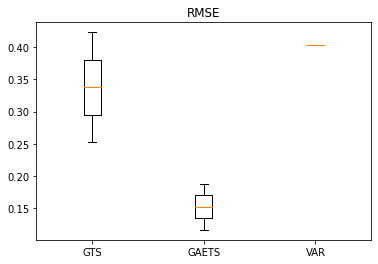

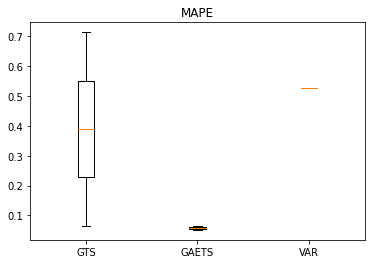

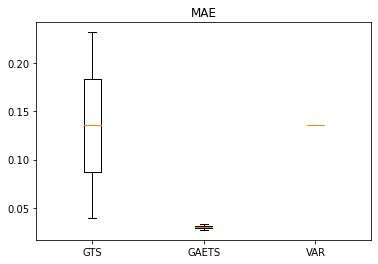

In [ ]:
""" Score Visualisation """

score_ticks = ["RMSE", "MAPE", "MAE"]
list_models = ["GTS", "GAETS", "VAR"]

for score_name in score_ticks:
  
  plt.title(score_name)
  scoreDF = mc_scores_df[[score_name]]
  for i, model_name in enumerate(list_models):
    score_value = scoreDF[scoreDF.index == model_name].values
    plt.boxplot(score_value, positions=[i], showfliers=False)
  plt.xticks(range(len(list_models)), list_models)
  plt.plot()
  plt.show()


## debug batch process

In [ ]:
import copy 
temp_supervisor_gts = copy.copy(supervisor_gts)

In [ ]:
""" GTS """
gts_test_iterator = create_test_iterator(temp_supervisor_gts, supervisor_config, "data/graphbatt/test")
gts_rmses = []
gts_mapes = []
gts_maes = []
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = temp_supervisor_gts._prepare_data(_x, _y)
  temp_supervisor_gts.GTS_model = temp_supervisor_gts.GTS_model.train()
  output, mid_output = temp_supervisor_gts.GTS_model(label, x, temp_supervisor_gts._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    gts_prediction = output[:, i, :].numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

np.median(gts_rmses), np.median(gts_mapes), np.median(gts_maes)

0it [00:00, ?it/s]

2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable parameters 2596563
2021-09-22 22:45:32,248 - INFO - Total trainable

(0.2696873, 0.08584814, 0.05198005)

In [ ]:
# load model and test dataset
args = DummyTrainArgs(config_filename="data/model/para_graphbatt.yaml", use_cpu_only=False, temperature=0.5)
with open(args.config_filename) as f:
    supervisor_config = yaml.load(f)
    save_adj_name = args.config_filename[11:-5]
    supervisor_gaets = GAETSSupervisor(save_adj_name, temperature=args.temperature, **supervisor_config)
    supervisor_gaets.train()


2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory: data/model/GAETS_DR_2_h_320_64_lr_0.005_bs_64_0922223401/
2021-09-22 22:34:01,882 - INFO - Log directory

2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 22:34:09,889 - INFO - Start training ...
2021-09-22 2

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.2115, val_mae: 5.1531
2021-09-22 22:35:01,867 - INFO - Epoch [0/2] (21) train_mae: 3.21

training loss,1.99976
validation loss,5.22283


training loss,█▁
validation loss,▁█


In [ ]:
supervisor_gts = copy.copy(temp_supervisor_gts)

In [ ]:
# get largest epoch
# files = os.listdir("models/GTS")
# largestGTSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
# files = os.listdir("models/GAETS")
# largestGAETSEpoch = max([int(re.search("epo(.+?).tar", x).group(1)) for x in files])
# print("best GTS epoch: {} and GAETS epoch: {}".format(largestGTSEpoch, largestGAETSEpoch))

# # Load Model
# supervisor_gts._epoch_num = largestGTSEpoch
# supervisor_gts.load_model()
# supervisor_gaets._epoch_num = largestGAETSEpoch
# supervisor_gaets.load_model()
# label = "with_regularization"
# temp_gts = supervisor_gts.temperature
# temp_gaets = supervisor_gaets.temperature
# gumbel_soft = True
batches_seen = 1

# get test data
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

"""
COMPARE PERFORMANCE
"""
# for each batch
var_rmses = []
var_mapes = []
var_maes = []
gts_rmses = []
gts_mapes = []
gts_maes = []
gaets_rmses = []
gaets_mapes = []
gaets_maes = []

# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  """ GAETS """
  x, y = supervisor_gaets._prepare_data(_x, _y)
  supervisor_gaets.GTS_model = supervisor_gaets.GTS_model.train()
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    gaets_prediction = output[:, i, :].numpy()
    gaets_rmse = masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mape = masked_mape_np(preds=gaets_prediction, labels=labels, null_val=0)
    gaets_mae = masked_mae_np(preds=gaets_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gaets_rmse) < np.float("inf"):
      gaets_rmses.append(gaets_rmse)
    if abs(gaets_mape) < np.float("inf"):
      gaets_mapes.append(gaets_mape)
    if abs(gaets_mae) < np.float("inf"):
      gaets_maes.append(gaets_mae)

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    input = x[:, i, :].numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 320)

    var_rmse = masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)
    var_mape = masked_mape_np(preds=var_prediction, labels=labels, null_val=0)
    var_mae = masked_mae_np(preds=var_prediction, labels=labels, null_val=0)

    # keep track
    if abs(var_rmse) < np.float("inf"):
      var_rmses.append(var_rmse)
    if abs(var_mape) < np.float("inf"):
      var_mapes.append(var_mape)
    if abs(var_mae) < np.float("inf"):
      var_maes.append(var_mae)

""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  supervisor_gts.GTS_model = supervisor_gts.GTS_model.train()
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    gts_prediction = output[:, i, :].numpy()
    gts_rmse = masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mape = masked_mape_np(preds=gts_prediction, labels=labels, null_val=0)
    gts_mae = masked_mae_np(preds=gts_prediction, labels=labels, null_val=0)

    # keep track
    if abs(gts_rmse) < np.float("inf"):
      gts_rmses.append(gts_rmse)
    if abs(gts_mape) < np.float("inf"):
      gts_mapes.append(gts_mape)
    if abs(gts_mae) < np.float("inf"):
      gts_maes.append(gts_mae)

"""
get score
"""
scoreMedianDict = {
  "GAETS": {
      "RMSE": np.median(gaets_rmses), 
      "MAPE": np.median(gaets_mapes), 
      "MAE": np.median(gaets_maes), 
      "RMS data points": len(gaets_rmses), 
      "MAPE data points": len(gaets_mapes), 
      "MAE data points": len(gaets_maes),
      "Best Epoch": largestGAETSEpoch
  },
  "GTS": {
      "RMSE": np.median(gts_rmses), 
      "MAPE": np.median(gts_mapes), 
      "MAE": np.median(gts_maes), 
      "RMS data points": len(gts_rmses), 
      "MAPE data points": len(gts_mapes), 
      "MAE data points": len(gts_maes),
      "Best Epoch": largestGTSEpoch
  },
  "VAR": {
      "RMSE": np.median(var_rmses), 
      "MAPE": np.median(var_mapes), 
      "MAE": np.median(var_maes), 
      "RMS data points": len(var_rmses), 
      "MAPE data points": len(var_mapes), 
      "MAE data points": len(var_maes),
      "Best Epoch": -1
  },
}
print(mc_round, scoreMedianDict)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:96: RuntimeWarning: overflow encountered in true_divide
  mape = np.abs(np.divide(np.subtract(preds, labels).astype('float32'), labels))
/content/drive/MyDrive/PhD/MLCollective/graphbatt/GTS/lib/metrics.py:70: RuntimeWarning: overflow encountered in square
  rmse = np.square(np.subtract(preds, labels)).astype('float32')


0it [00:00, ?it/s]

1 {'GAETS': {'RMSE': 0.30525815, 'MAPE': 0.38186175, 'MAE': 0.12410286, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 2}, 'GTS': {'RMSE': 0.26933032, 'MAPE': 0.08563516, 'MAE': 0.05185799, 'RMS data points': 1344, 'MAPE data points': 1344, 'MAE data points': 1344, 'Best Epoch': 0}, 'VAR': {'RMSE': 0.40325296, 'MAPE': 0.52542484, 'MAE': 0.13562584, 'RMS data points': 1290, 'MAPE data points': 1316, 'MAE data points': 1316, 'Best Epoch': -1}}


In [ ]:
"""
get score
"""
scoreMedianDict = {
  "GAETS": {
      "RMSE": np.median(gaets_rmses), 
      "MAPE": np.median(gaets_mapes), 
      "MAE": np.median(gaets_maes), 
      "RMS data points": len(gaets_rmses), 
      "MAPE data points": len(gaets_mapes), 
      "MAE data points": len(gaets_maes),
      "Best Epoch": largestGAETSEpoch
  },
  "GTS": {
      "RMSE": np.median(gts_rmses), 
      "MAPE": np.median(gts_mapes), 
      "MAE": np.median(gts_maes), 
      "RMS data points": len(gts_rmses), 
      "MAPE data points": len(gts_mapes), 
      "MAE data points": len(gts_maes),
      "Best Epoch": largestGTSEpoch
  },
  "VAR": {
      "RMSE": np.median(var_rmses), 
      "MAPE": np.median(var_mapes), 
      "MAE": np.median(var_maes), 
      "RMS data points": len(var_rmses), 
      "MAPE data points": len(var_mapes), 
      "MAE data points": len(var_maes),
      "Best Epoch": -1
  },
}
scoreMedianDict

{'GAETS': {'Best Epoch': 2,
  'MAE': 0.12410286,
  'MAE data points': 1344,
  'MAPE': 0.38186175,
  'MAPE data points': 1344,
  'RMS data points': 1344,
  'RMSE': 0.30525815},
 'GTS': {'Best Epoch': 0,
  'MAE': 0.05185799,
  'MAE data points': 1344,
  'MAPE': 0.08563516,
  'MAPE data points': 1344,
  'RMS data points': 1344,
  'RMSE': 0.26933032},
 'VAR': {'Best Epoch': -1,
  'MAE': 0.13562584,
  'MAE data points': 1316,
  'MAPE': 0.52542484,
  'MAPE data points': 1316,
  'RMS data points': 1290,
  'RMSE': 0.40325296}}

0it [00:00, ?it/s]

2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable parameters 3072347
2021-09-22 21:05:38,499 - INFO - Total trainable

0it [00:00, ?it/s]

2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable parameters 2596563
2021-09-22 21:05:39,882 - INFO - Total trainable

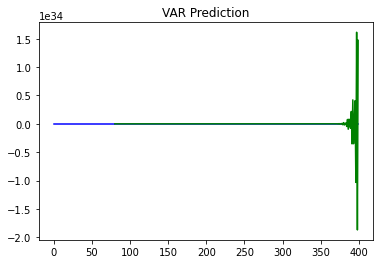

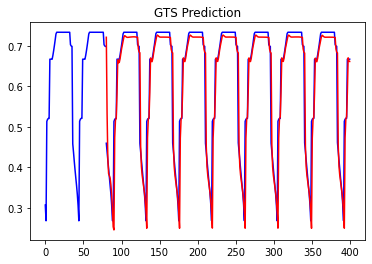

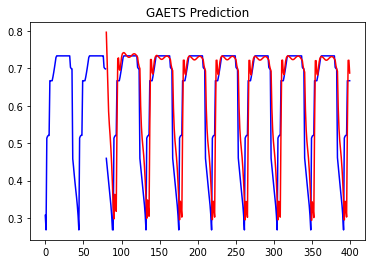

1


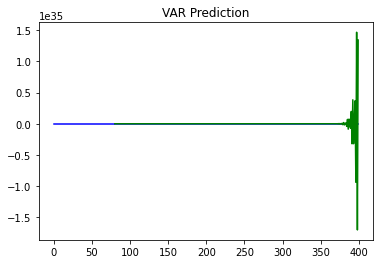

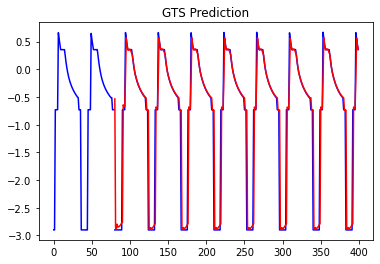

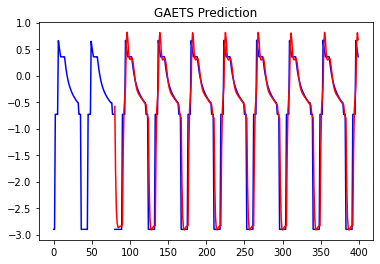

2


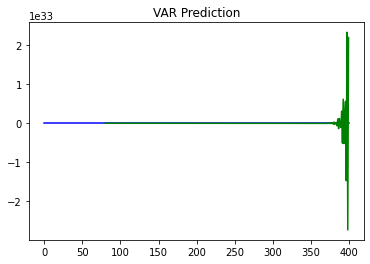

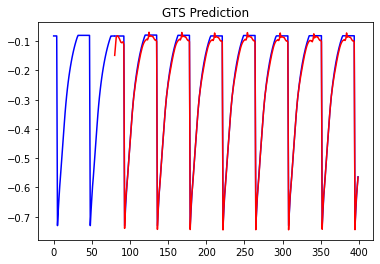

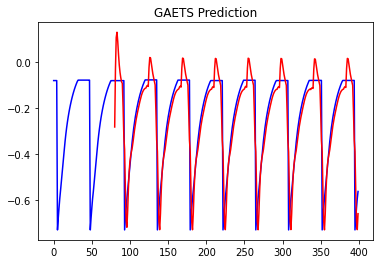

3


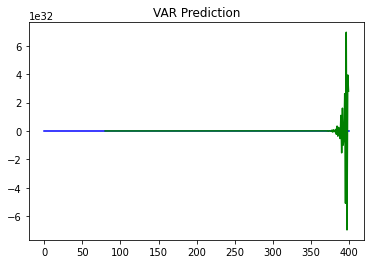

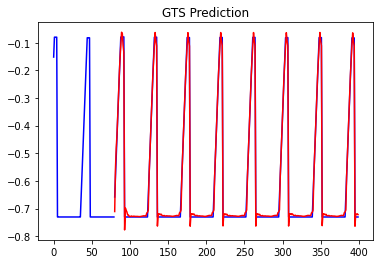

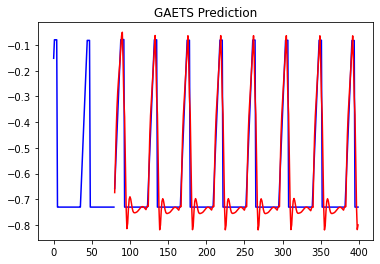

4


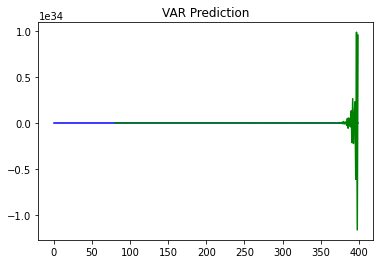

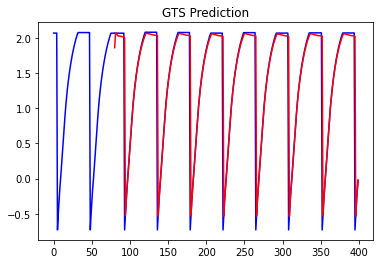

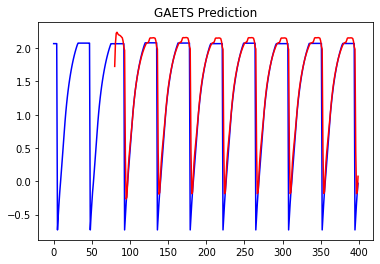

5


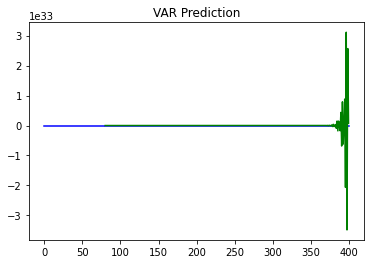

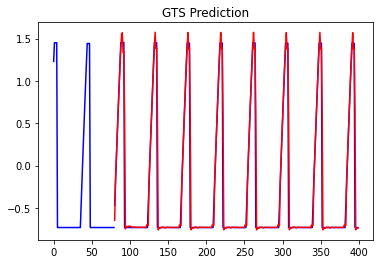

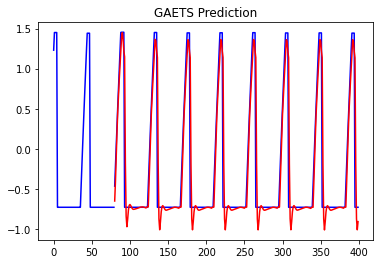

In [ ]:
# debug

"""
Example Visualisation
"""
gts_test_iterator = create_test_iterator(supervisor_gts, supervisor_config, "data/graphbatt/test")
gaets_test_iterator = create_test_iterator(supervisor_gaets, supervisor_config, "data/graphbatt/test")

""" GAETS """
# for each batch
for batch_idx, (_x, _y) in tqdm(enumerate(gaets_test_iterator)):
  x, y = supervisor_gaets._prepare_data(_x, _y)
  output, mid_output, _train_feas_rec = supervisor_gaets.GTS_model(label, x, supervisor_gaets._train_feas, temp_gaets, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    print(labels)
    gaets_prediction = output[:, i, :].numpy()
    break

  """ VAR """
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    print(labels)
    input = x[:, i, :].numpy()

    # fit VAR model on input
    var_model = VAR(input)
    # TODO: choose best lag
    var_result = var_model.fit(31)
    var_prediction = var_result.forecast(input, 320)
    break

  break

""" GTS """
for batch_idx, (_x, _y) in tqdm(enumerate(gts_test_iterator)):
  x, y = supervisor_gts._prepare_data(_x, _y)
  output, mid_output = supervisor_gts.GTS_model(label, x, supervisor_gts._train_feas, temp_gts, gumbel_soft, y, batches_seen)
  output = output.detach()
  # for each batch
  for i in range(x.shape[1]):
    labels = y[:, i, :].numpy()
    print(labels)
    gts_prediction = output[:, i, :].numpy()
    break
  break


# for each measurement
for i in range(6):

  print(i)

  plt.title("VAR Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), var_prediction[:, i], c="g")
  plt.show()

  plt.title("GTS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gts_prediction[:, i], c="r")
  plt.show()

  plt.title("GAETS Prediction")
  plt.plot(range(input.shape[0]), input[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), labels[:, i], c="b")
  plt.plot(range(input.shape[0], input.shape[0] + labels.shape[0]), gaets_prediction[:, i], c="r")
  plt.show()

In [ ]:
np.max(gts_rmses)

1.2620996

In [ ]:
masked_rmse_np(preds=gts_prediction, labels=labels, null_val=0)

0.2864096

In [ ]:
masked_rmse_np(preds=gaets_prediction, labels=labels, null_val=0)

0.77305436

In [ ]:
masked_rmse_np(preds=var_prediction, labels=labels, null_val=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


inf